In [2]:
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [3]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'Stackoverflow')

6053888/6053168 [==============================] - 0s 0us/step


In [5]:
dataset_dir

'./Stackoverflow'

In [26]:
batch_size = 32

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', batch_size=batch_size, validation_split=0.2, subset='training', seed=42)

raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', batch_size=batch_size, validation_split=0.2, subset='validation', seed=42)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'test', batch_size=batch_size)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [7]:
print(raw_train_ds.class_names)

['csharp', 'java', 'javascript', 'python']


In [ ]:
for text_batch,label_batch in raw_train_ds.take(1):
  for i in range(5):
    print(text_batch.numpy()[i])
    print(label_batch.numpy()[i])
    print()

We ahave to Prepare the Data

In [9]:
max_features = 5000
embedding_dim = 128
sequence_length = 500

In [10]:
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [11]:
# Make a text-only dataset (no labels) and call adapt
text_ds = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

In [15]:
model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer='adam', 
    metrics=['accuracy'])

In [16]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5)

Epoch 1/5
200/200 [==============================] - 11s 49ms/step - loss: 1.3799 - accuracy: 0.2962 - val_loss: 1.3565 - val_accuracy: 0.4050
Epoch 2/5
200/200 [==============================] - 8s 39ms/step - loss: 1.3382 - accuracy: 0.4404 - val_loss: 1.2849 - val_accuracy: 0.4956
Epoch 3/5
200/200 [==============================] - 8s 38ms/step - loss: 1.2528 - accuracy: 0.5614 - val_loss: 1.1716 - val_accuracy: 0.6494
Epoch 4/5
200/200 [==============================] - 8s 38ms/step - loss: 1.1369 - accuracy: 0.6486 - val_loss: 1.0543 - val_accuracy: 0.7063
Epoch 5/5
200/200 [==============================] - 8s 39ms/step - loss: 1.0247 - accuracy: 0.6853 - val_loss: 0.9518 - val_accuracy: 0.7375


In [17]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 4s 17ms/step - loss: 0.9768 - accuracy: 0.7099
Loss:  0.9767670631408691
Accuracy:  0.7098749876022339


In [18]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

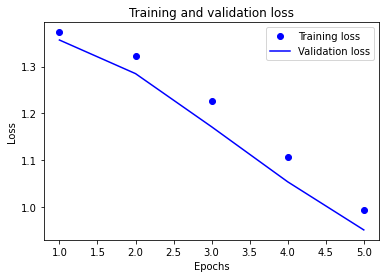

In [20]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

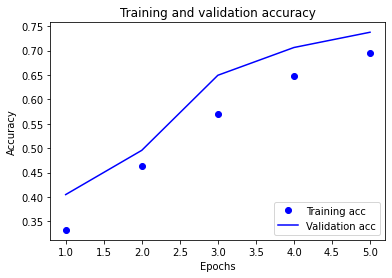

In [21]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()